In [1]:
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

2024-09-20 10:35:33.633719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 10:35:33.665660: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
jfunc_all_data = xr.load_dataset("./data/jfunction_data_med.nc")
jfunc_all_data

<xarray.Dataset>
Dimensions:                 (Radius: 180, Monte Carlo Simulation: 9895,
                             class: 3, y: 1)
Coordinates:
  * Radius                  (Radius) float64 0.0 0.01676 0.03352 ... 2.983 3.0
  * Monte Carlo Simulation  (Monte Carlo Simulation) float64 1.0 ... 9.895e+03
  * class                   (class) int64 0 1 2
Dimensions without coordinates: y
Data variables:
    v                       (class, Monte Carlo Simulation, y, Radius) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.3 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    contact:      Niklas.luther@zeu.uni-giessen.de
    history:      Wed Sep 18 15:48:58 2024: cdo mermean Process=hardcore_INTE...
    CDO:          Climate Data Operators version 2.0.3 (https://mpimet.mpg.de...

In [3]:
X_raw = jfunc_all_data.v.to_numpy()
X_raw.shape

(3, 9895, 1, 180)

In [4]:
X_raw_0 = X_raw[0, ~np.any(np.isnan(X_raw[0]), axis=(1,2))]
X_raw_1 = X_raw[1, ~np.any(np.isnan(X_raw[1]), axis=(1,2))]
X_raw_2 = X_raw[2, ~np.any(np.isnan(X_raw[2]), axis=(1,2))]
X_raw_0.shape, X_raw_1.shape, X_raw_2.shape

((7883, 1, 180), (5362, 1, 180), (9895, 1, 180))

(23140, 180, 1)


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

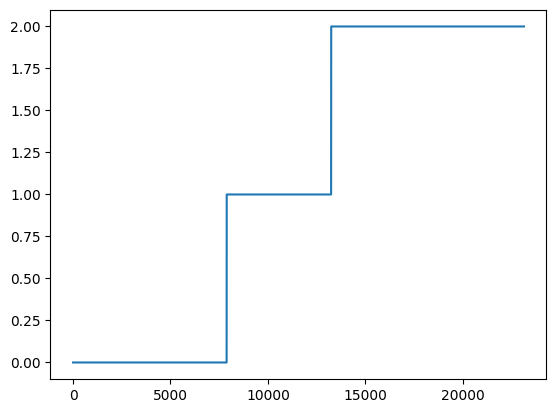

In [5]:
X = np.concatenate([X_raw_0, X_raw_1, X_raw_2])
X = X.transpose((0,2,1))
print(X.shape)

y_base = np.concatenate([np.zeros(X_raw_0.shape[0], dtype=int), np.ones(X_raw_1.shape[0], dtype=int), np.full(X_raw_2.shape[0], 2)]).reshape((-1, 1))
oh_enc = OneHotEncoder(sparse_output=False)
y = oh_enc.fit_transform(y_base)
plt.plot(y_base)
y

In [6]:
X_train_base, X_test_base, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
print(X_train_base.shape)
print(X_test_base.shape)

abs_max = np.abs(X_train_base - 1).max()

X_train = (X_train_base - 1)/abs_max
X_test = (X_test_base - 1)/abs_max

# X_scaler = StandardScaler()
# X_train = X_scaler.fit_transform(X_train_base.reshape((-1, 1))).reshape(X_train_base.shape)
# X_test = X_scaler.transform(X_test_base.reshape((-1, 1))).reshape(X_test_base.shape)

(18512, 180, 1)
(4628, 180, 1)


[Text(0.5, 1.0, 'Test')]

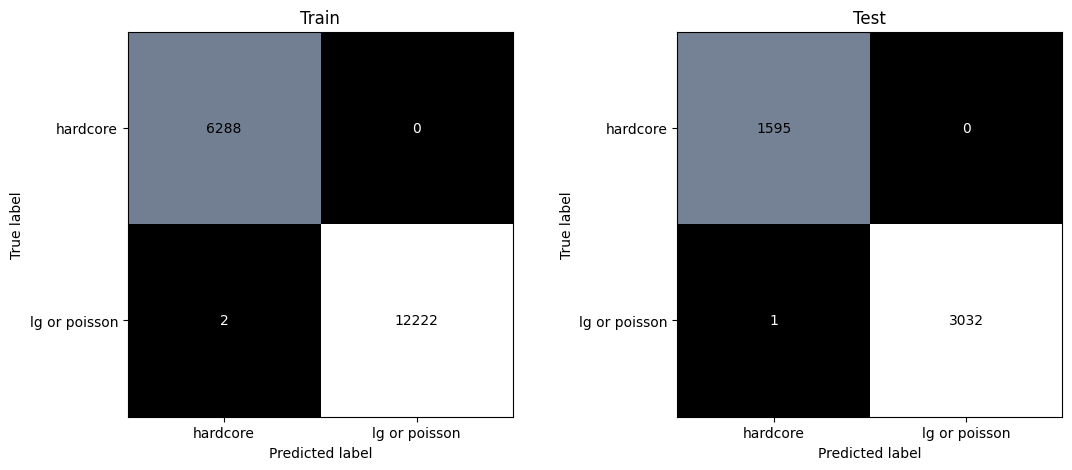

In [7]:
y_train_h = 1-y_train[:, 0]
y_test_h = 1-y_test[:, 0]

l_model = LogisticRegression()
# l_model = DecisionTreeClassifier()
# l_model = GaussianNB()
l_model = l_model.fit(X_train.squeeze(), y_train_h)
pred_train_h = l_model.predict(X_train.squeeze())
pred_test_h = l_model.predict(X_test.squeeze())

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ConfusionMatrixDisplay.from_predictions(y_train_h, pred_train_h, ax=ax[0], colorbar=False, cmap="bone", display_labels=["hardcore", "lg or poisson"])
ax[0].set(title="Train")
ConfusionMatrixDisplay.from_predictions(y_test_h, pred_test_h, ax=ax[1], colorbar=False, cmap="bone", display_labels=["hardcore", "lg or poisson"])
ax[1].set(title="Test")

In [8]:
X_train_step2 = X_train[pred_train_h == 1]
X_test_step2 = X_test[pred_test_h == 1]
print(pred_test_h.shape)
print(y_test.shape)
print(y_train.shape)
print(pred_train_h.shape)
y_train_step2 = y_train[pred_train_h == 1, [2]]
y_test_step2 = y_test[pred_test_h == 1, [2]]
print(X_train_step2.shape)
print(X_test_step2.shape)
print(y_train_step2.shape)
print(y_test_step2.shape)

(4628,)
(4628, 3)
(18512, 3)
(18512,)
(12222, 180, 1)
(3032, 180, 1)
(12222,)
(3032,)


In [19]:
x_input = keras.Input(X.shape[1:])
x = x_input
x = keras.layers.Conv1D(256, 5, padding="same", activation='relu')(x)
x = keras.layers.MaxPooling1D()(x)
x = keras.layers.Conv1D(126, 5, padding="same", activation='relu')(x)
x = keras.layers.MaxPooling1D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(500, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(300, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(x_input, x)

# optimizer = keras.optimizers.Adam(5e-6)
optimizer = keras.optimizers.RMSprop(2e-5)
model.compile(optimizer=optimizer, loss="bce")
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 1)]          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 180, 256)          1536      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 90, 256)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 90, 126)           161406    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 45, 126)          0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 5670)              0   

Total params: 3,149,043
Trainable params: 3,149,043
Non-trainable params: 0
_________________________________________________________________


In [20]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=40, mode="min", restore_best_weights=True)
history = model.fit(X_train_step2, y_train_step2, epochs=10000, validation_split=0.15, callbacks=[early_stopping])
# history = model.fit(X_train_step2, y_train_step2, epochs=100, validation_split=0.15)

Epoch 1/10000


325/325 [==============================] - 2s 5ms/step - loss: 0.4192 - val_loss: 0.2344
Epoch 2/10000
325/325 [==============================] - 1s 4ms/step - loss: 0.2117 - val_loss: 0.2023
Epoch 3/10000
325/325 [==============================] - 1s 5ms/step - loss: 0.2068 - val_loss: 0.2064
Epoch 4/10000
325/325 [==============================] - 1s 5ms/step - loss: 0.2053 - val_loss: 0.1971
Epoch 5/10000
325/325 [==============================] - 2s 5ms/step - loss: 0.2058 - val_loss: 0.2001
Epoch 6/10000
325/325 [==============================] - 2s 5ms/step - loss: 0.2046 - val_loss: 0.1924
Epoch 7/10000
325/325 [==============================] - 2s 5ms/step - loss: 0.2034 - val_loss: 0.1998
Epoch 8/10000
325/325 [==============================] - 2s 5ms/step - loss: 0.2018 - val_loss: 0.1912
Epoch 9/10000
325/325 [==============================] - 2s 5ms/step - loss: 0.2026 - val_loss: 0.1926
Epoch 10/10000
325/325 [==============================] - 2s 5ms/step - loss: 0.2024 - 

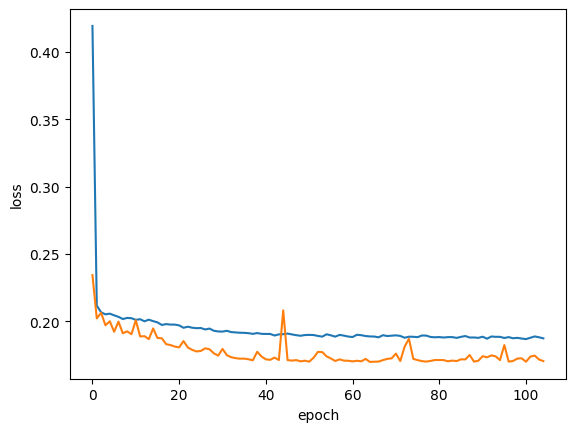

In [21]:
history_curve = history.history
history_curve["epoch"] = list(range(len(history_curve["loss"])))
fig, ax = plt.subplots()
sns.lineplot(history_curve, x="epoch", y="loss", ax=ax)
sns.lineplot(history_curve, x="epoch", y="val_loss", ax=ax)
plt.show()

382/382 [==============================] - 0s 406us/step
[0. 1.]
[0 1]
95/95 [==============================] - 0s 494us/step
[0. 1.]
[0 1]


[Text(0.5, 1.0, 'Test')]

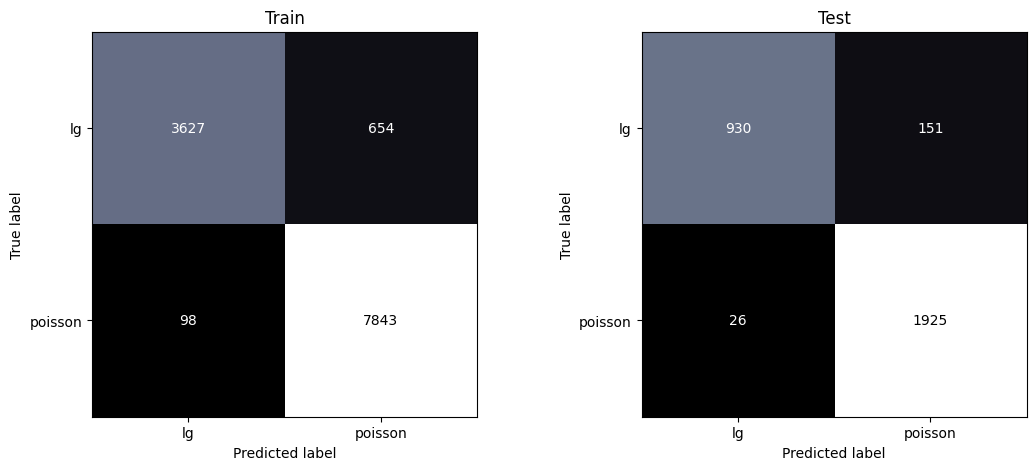

In [22]:
# oh_enc2 = OneHotEncoder(handle_unknown="ignore")
# oh_enc2.fit([[0],[1]])

pred_train = (model.predict(X_train_step2) > 0.5).astype(int)
y_train_disp = y_train_step2
pred_train_disp = pred_train
# y_train_disp = oh_enc2.inverse_transform(y_train_step2)
# pred_train_disp = oh_enc2.inverse_transform(pred_train)
# print(pred_train_disp)
print(np.unique(y_train_step2))
print(np.unique(pred_train_disp))

pred_test = (model.predict(X_test_step2) > 0.5).astype(int)
y_test_disp = y_test_step2
pred_test_disp = pred_test
# y_test_disp = oh_enc2.inverse_transform(y_test_step2)
# pred_test_disp = oh_enc2.inverse_transform(pred_test)
print(np.unique(y_test_step2))
print(np.unique(pred_test_disp))

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ConfusionMatrixDisplay.from_predictions(y_train_disp, pred_train_disp, ax=ax[0], colorbar=False, cmap="bone", display_labels=["lg", "poisson"])
ax[0].set(title="Train")
ConfusionMatrixDisplay.from_predictions(y_test_disp, pred_test_disp, ax=ax[1], colorbar=False, cmap="bone", display_labels=["lg", "poisson"])
ax[1].set(title="Test")